In [62]:
# Force garbage collection
import gc
gc.collect()

2924

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve

In [6]:
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2


In [8]:
# read the merged data
# mod_data = pd.read_parquet('../Clean_Data/Model_Data/2001_2020_Downsample/Features_w_Label_Downsampled.parquet')
#Eval_data = pd.read_parquet('../Clean_Data/Model_Data/2020/Features_w_Label_2020_OOT.parquet')
Eval_data = pd.read_parquet('../Clean_Data/Model_Data/Evaluation/Features_w_Label/2020_features_w_label.parquet')

In [9]:
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [36]:
feature_list = [#'day',
                    'dead_fuel_moisture_1000hr',
                    'dead_fuel_moisture_100hr', 
                    #'pdsi_pre_interpolated',
                    'pdsi', 
                    #'pdsi_class', 
                    'max_air_temperature',
                    'max_relative_humidity', 
                    #'max_wind_speed', 
                    'min_air_temperature',
                    'min_relative_humidity', 
                    'precipitation_amount', 
                    'specific_humidity',
                    'surface_downwelling_shortwave_flux_in_air',
                    #'wind_from_direction',
                    'wind_speed', 
                    'wind_direction_category', 
                    'SWE', 
                    'Band1',
                    'LAI',
                    'IS_FIRE',
                    #'NWCG_CAUSE_CLASSIFICATION', 
                    #'min_FIRE_SIZE', 
                    #'max_FIRE_SIZE',
                    #'veg_type_details', 
                    #'fire_attribute', 
                    'veg', 
                    'slope_avg', 
                    'slope_max',
                    'road_density_km_km2']

In [35]:
Eval_data.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'wind_direction_category', 'SWE',
       'Band1', 'LAI', 'pdsi', 'IS_FIRE', 'NWCG_CAUSE_CLASSIFICATION',
       'min_FIRE_SIZE', 'max_FIRE_SIZE', 'Year', 'veg_type_details',
       'fire_attribute', 'veg', 'slope_avg', 'slope_max',
       'road_density_km_km2'],
      dtype='object')

In [55]:
# filter wind direction category to exclude  W and NW
test = Eval_data[~Eval_data['wind_direction_category'].isin(['W', 'NW'])]
# reassign categories in wind direction category to remove non-existence of W and NW
test['wind_direction_category'] = test['wind_direction_category'].cat.remove_unused_categories()
test_dummy = pd.get_dummies(test, columns=['wind_direction_category'])

In [54]:
test_dummy.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'SWE', 'Band1', 'LAI', 'pdsi',
       'IS_FIRE', 'NWCG_CAUSE_CLASSIFICATION', 'min_FIRE_SIZE',
       'max_FIRE_SIZE', 'Year', 'veg_type_details', 'fire_attribute', 'veg',
       'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_SE',
       'wind_direction_category_S', 'wind_direction_category_SW',
       'wind_direction_category_W', 'wind_direction_category_NW'],
      dtype='object')

In [ ]:
# define a function to plot the wind direction
def plot_wind_direction(data):
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    directions = np.deg2rad(data['wind_from_direction'])
    ax.scatter(directions, np.ones_like(directions), c='r', label='Present Directions')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    plt.title("Wind Directions")
    plt.legend()
    plt.show()

In [103]:
def data_prep(data, eval_dat=False, eval_year = 2020, 
              feature_list = ['IS_FIRE','SWE'], area = 'all', 
              wind_speed_threshold = 6, 
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):
    # keep human fire
    data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
    data = data[(data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (data['IS_FIRE'] == 0)]
    # print after filtering the value count of NWCG_CAUSE_CLASSIFICATION in a sentence
    print('After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:')
    print(data['NWCG_CAUSE_CLASSIFICATION'].value_counts())

    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        # print year column is added in a sentence
        print('Year column is added')

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence
        print('Month column is added')

    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]
    # print the nunique values of month in a sentence
    print('The unique values of month is:')
    print(data['Month'].unique())

    # if it is not evaluation data, then filter the year to be between year-6 and year-1
    if not eval_dat:
        data = data[(data['Year'] >= (eval_year - 6)) & (data['Year'] <= (eval_year - 1))]
        # print after filtering, the min and max year is
        print('After filtering, the min and max year is:')
        print(data['Year'].min(), data['Year'].max())
    # if it is evaluation data, ensure the year is eval_year
    else:
        # check the unique values of year
        print('The unique values of year is:')
        print(data['Year'].unique())
        # confirm the year is eval_year
        assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'

    if area == "south":
        data = data[data['lat'] < 35.75]
        # print the min and max lat in a sentence
        print('The min and max lat is:')
        print(data['lat'].min(), data['lat'].max())
    elif area == "north":
        data = data[data['lat'] >= 35.75]
        # print the min and max lat in a sentence
        print('The min and max lat is:')
        print(data['lat'].min(), data['lat'].max())

    if wind_speed_threshold > 0:
        # filter data to be >= wind_direction_threshold
        data = data[data['max_wind_speed'] >= wind_speed_threshold]
        # print the min and max wind speed in a sentence
        print('The min and max wind speed is:')
        print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    plot_wind_direction(data)

    data['wind_direction_category'] = data['wind_direction_category'].cat.remove_unused_categories()

    data['veg'] = data['veg'].astype('category')
    data['veg'] = data['veg'].cat.remove_unused_categories()

    data = data[feature_list]
    cat_columns = ['wind_direction_category','veg']
    # check if both cat_columns are in data
    if all(col in data.columns for col in cat_columns):
        data = pd.get_dummies(data, columns=cat_columns)
    else:
        print('One of the columns is not in data')

    # PRINT shape of data, and the mean and sum of IS_FIRE
    print('The shape of data is:')
    print(data.shape)
    print('The mean of IS_FIRE is:')
    print(data['IS_FIRE'].mean())
    print('The count of IS_FIRE is:')
    print(data['IS_FIRE'].sum())

    return data

In [82]:
def calculate_precision_recall(y_true, y_pred_proba, threshold, print_output=False):
    y_pred = (y_pred_proba > threshold).astype(int)
    confusion = confusion_matrix(y_true, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    if print_output:
        print(f'Threshold: {threshold:.2f}')
        print(f'Precision: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print("Confusion Matrix")
        print(pd.DataFrame(confusion, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos']))
    # get TP, TN, FP, FN
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    return TP, TN, FP, FN, precision, recall, f1

def evaluate_model(model, test_data, features, label_col, threshold = 0.5, print_output=False, plot_ROC=False):
    X_test = test_data[features]
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = model.predict_proba(X_test)[:, 1]
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if print_output:
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if plot_ROC:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, threshold, print_output)
    return roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15

## North

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  6284671
'Human'                                                  4113
'Human', 'Missing data/not specified/undetermined'         93
'Human', 'Natural'                                          1
Name: count, dtype: int64
Month column is added
The unique values of month is:
[ 1 10 11 12]
The unique values of year is:
[2020]
The min and max lat is:
35.775000000000006 41.983333333333334
The min and max wind speed is:
0.4000000059604645 16.30000114440918


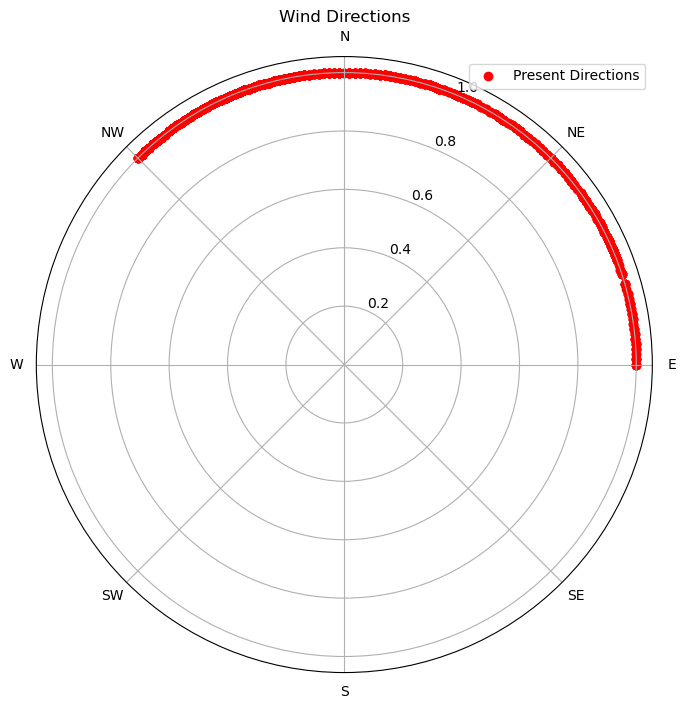

The shape of data is:
(188639, 39)
The mean of IS_FIRE is:
0.00040818706630124207
The count of IS_FIRE is:
77


In [104]:
# supress warnings
warnings.filterwarnings("ignore")
Eval_north = data_prep(Eval_data, eval_dat=True, 
                       eval_year=2020, 
                       feature_list=feature_list, 
                       area='north', 
                       wind_speed_threshold=6, 
                       wind_direction_range=[315, 90], month_list=[1,10,11,12])

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64
Year column is added
Month column is added
The unique values of month is:
[ 1 10 11 12]
After filtering, the min and max year is:
2014 2019
The min and max lat is:
35.775000000000006 41.983333333333334
The min and max wind speed is:
0.4000000059604645 19.899999618530273


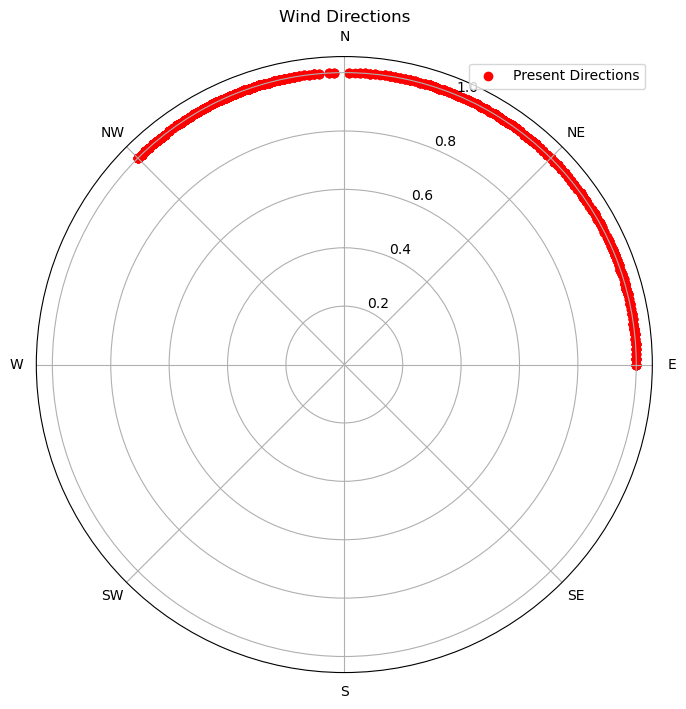

The shape of data is:
(103710, 39)
The mean of IS_FIRE is:
0.0024877061035579982
The count of IS_FIRE is:
258


In [107]:
Train_north = data_prep(mod_data, eval_dat=False,
                        eval_year=2020, 
                        feature_list=feature_list, 
                        area='north', 
                        wind_speed_threshold=6, 
                        wind_direction_range=[315, 90], month_list=[1,10,11,12])

In [66]:
Train_north.dtypes

dead_fuel_moisture_1000hr                    float32
dead_fuel_moisture_100hr                     float32
pdsi                                         float32
max_air_temperature                          float64
max_relative_humidity                        float32
min_air_temperature                          float64
min_relative_humidity                        float32
precipitation_amount                         float32
specific_humidity                            float32
surface_downwelling_shortwave_flux_in_air    float32
wind_speed                                   float32
SWE                                          float32
Band1                                        float32
LAI                                          float32
IS_FIRE                                        int32
slope_avg                                    float32
slope_max                                    float32
road_density_km_km2                          float64
wind_direction_category_N                     

In [112]:
# Train XGBoost model
X_train = Train_north.drop(columns=['IS_FIRE'])
y_train = Train_north['IS_FIRE']

# Define the parameters for a simpler model
params = {
    'max_depth': 3,  # Reduce the maximum depth of the trees
    'min_child_weight': 5,  # Increase the minimum sum of instance weight needed in a child
    #'gamma': 0.1,  # Increase the minimum loss reduction required to make a further partition
    #'subsample': 0.8,  # Reduce the subsample ratio of the training instances
    #'colsample_bytree': 0.8,  # Reduce the subsample ratio of columns when constructing each tree
    'learning_rate': 0.1,  # Increase the learning rate
    'n_estimators': 10,  # Reduce the number of boosting rounds
    'eval_metric':'logloss'
}

# Create the XGBoost model with the simpler parameters
model = xgb.XGBClassifier(**params)
mod_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [109]:
X_train.columns

Index(['dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'pdsi',
       'max_air_temperature', 'max_relative_humidity', 'min_air_temperature',
       'min_relative_humidity', 'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'SWE',
       'Band1', 'LAI', 'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Native Desert ',
       'veg_Native Grassland ', 'veg_Native Inland Scrub ',
       'veg_Native Oak Woodland ', 'veg_Native Wetland ',
       'veg_Non-native forest ', 'veg_Non-native grassland ',
       'veg_Non-native shrub ', 'veg_Riparian ', 'veg_Urban ', 'veg_Water '],
      dtype='object')

In [113]:
features = X_train.columns
evaluate_model(mod_1, Train_north, features, "IS_FIRE", print_output=True, plot_ROC=False)

ROC AUC: 1.00
Area Under Precision-Recall Curve (AUC-PR): 1.00
Threshold: 0.50
Precision: 100.00%
Recall: 98.45%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg    103452         0
True Pos         4       254


(1.0, 1.0, 254, 103452, 0, 4, 1.0, 0.9844961240310077, 0.9921875)

In [114]:
features = X_train.columns
evaluate_model(mod_1, Eval_north, features, "IS_FIRE", print_output=True, plot_ROC=False)

ROC AUC: 0.86
Area Under Precision-Recall Curve (AUC-PR): 0.00
Threshold: 0.50
Precision: 0.00%
Recall: 0.00%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg    188547        15
True Pos        77         0


(0.8631482538314244, 0.004841086942764144, 0, 188547, 15, 77, 0.0, 0.0, nan)

In [70]:
# print feature importance
feature_importances = pd.Series(mod_1.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

wind_direction_category_NE                   0.095890
Band1                                        0.073231
veg_Native Inland Scrub                      0.059227
veg_Native Coastal Sage Scrub                0.054956
dead_fuel_moisture_1000hr                    0.045810
min_relative_humidity                        0.045042
road_density_km_km2                          0.042875
dead_fuel_moisture_100hr                     0.038865
precipitation_amount                         0.038780
slope_max                                    0.036230
veg_Riparian                                 0.036140
veg_Native Conifer Forest                    0.035801
veg_Agriculture                              0.035764
max_relative_humidity                        0.035537
min_air_temperature                          0.035529
LAI                                          0.035438
surface_downwelling_shortwave_flux_in_air    0.033198
slope_avg                                    0.033140
wind_speed                  

## Shap Value

In [71]:
import shap

In [73]:
explainer = shap.Explainer(mod_1)
shap_values = explainer(X_train)

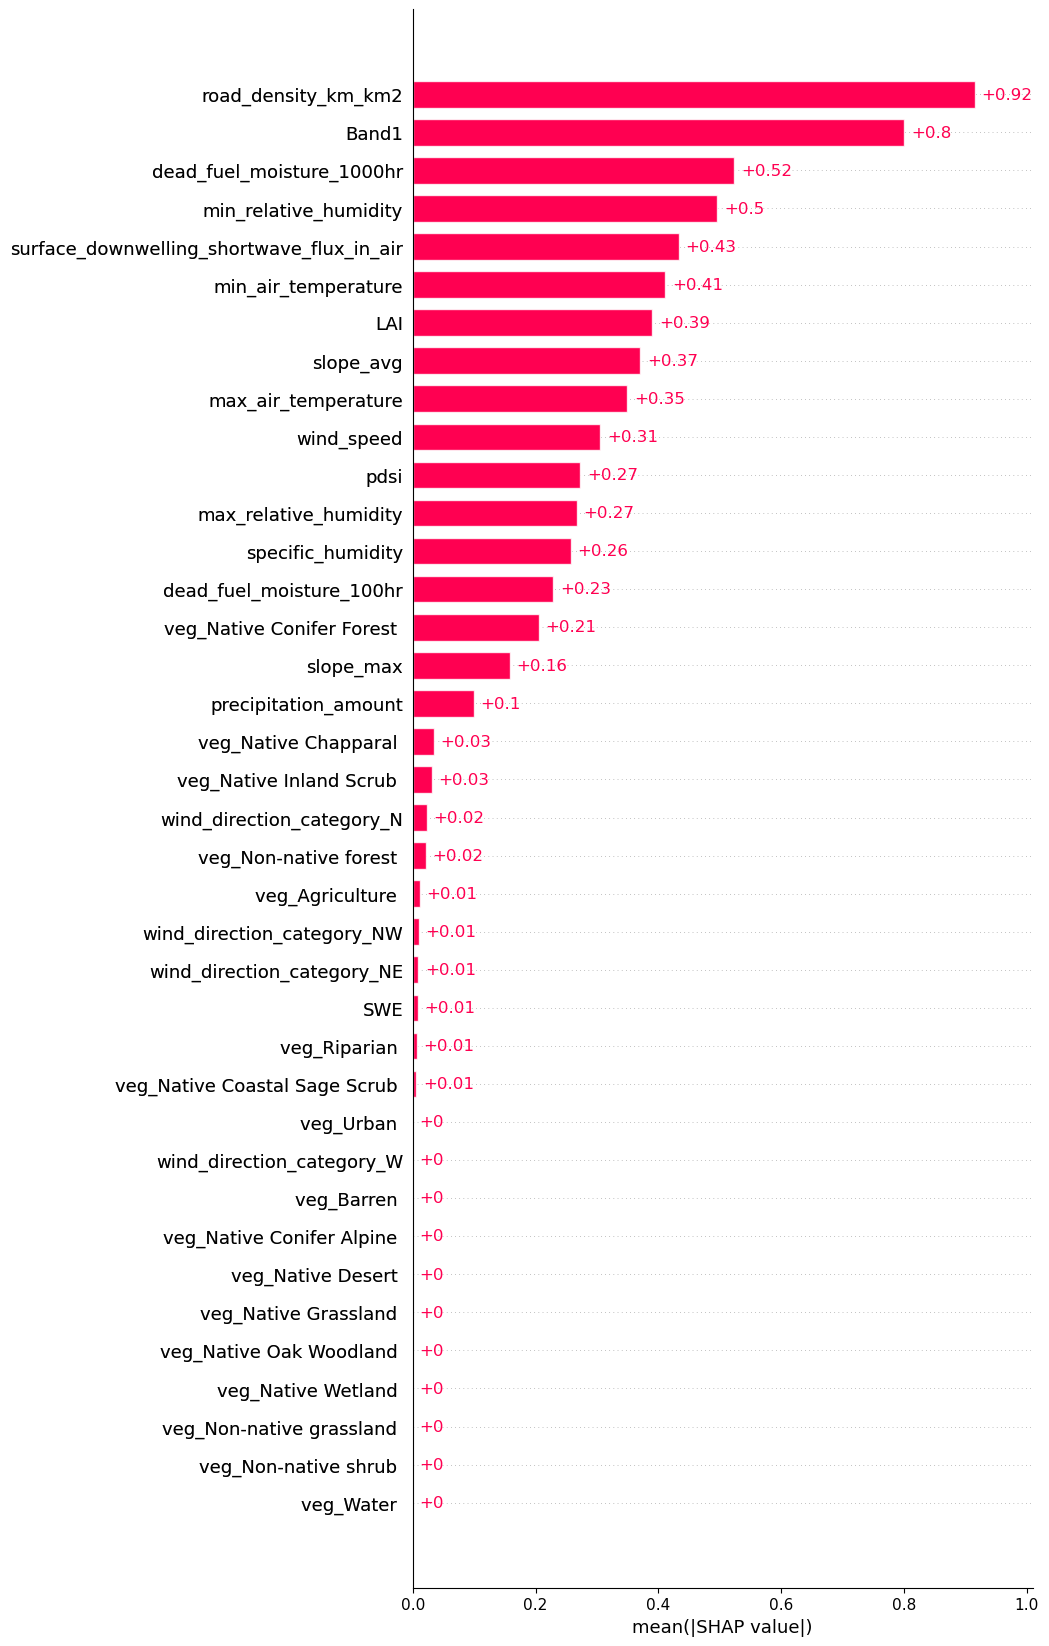

In [74]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(shap_values, max_display = 50)

## South

In [115]:
Eval_data['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       8630
Name: count, dtype: int64

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64
Year column is added
Month column is added
The unique values of month is:
[ 1  2  3  4  9 10 11 12]
After filtering, the min and max year is:
2014 2019
The min and max lat is:
32.525000000000006 35.733333333333334


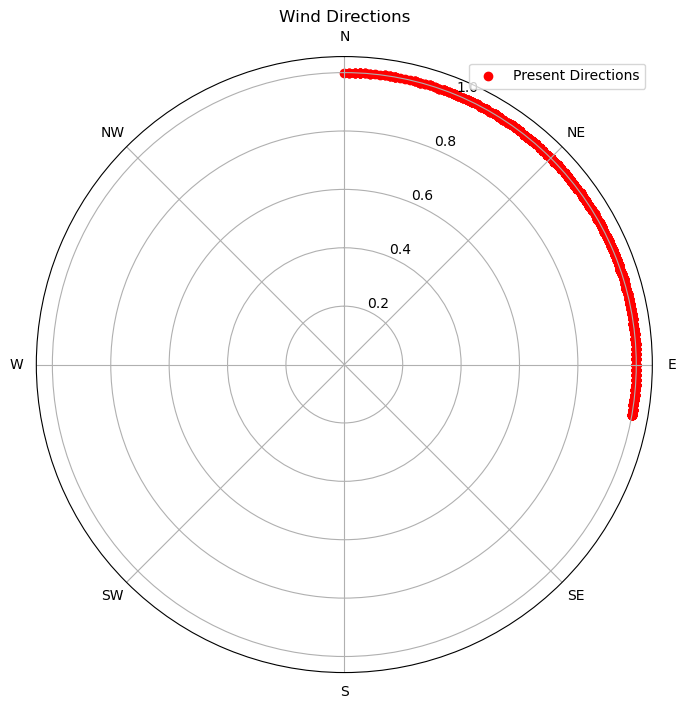

The shape of data is:
(61022, 39)
The mean of IS_FIRE is:
0.004916259709612927
The count of IS_FIRE is:
300


In [ ]:
Train_south = data_prep(mod_data, eval_dat=False,
                        eval_year=2020, 
                        feature_list=feature_list, 
                        area='south', 
                        wind_speed_threshold=0, 
                        wind_direction_range=[360, 100], 
                        month_list=[9,10,11,12,1,2,3,4])

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  6284671
'Human'                                                  4113
'Human', 'Missing data/not specified/undetermined'         93
'Human', 'Natural'                                          1
Name: count, dtype: int64
Month column is added
The unique values of month is:
[ 1  2  3  4  9 10 11 12]
The unique values of year is:
[2020]
The min and max lat is:
32.525000000000006 35.733333333333334


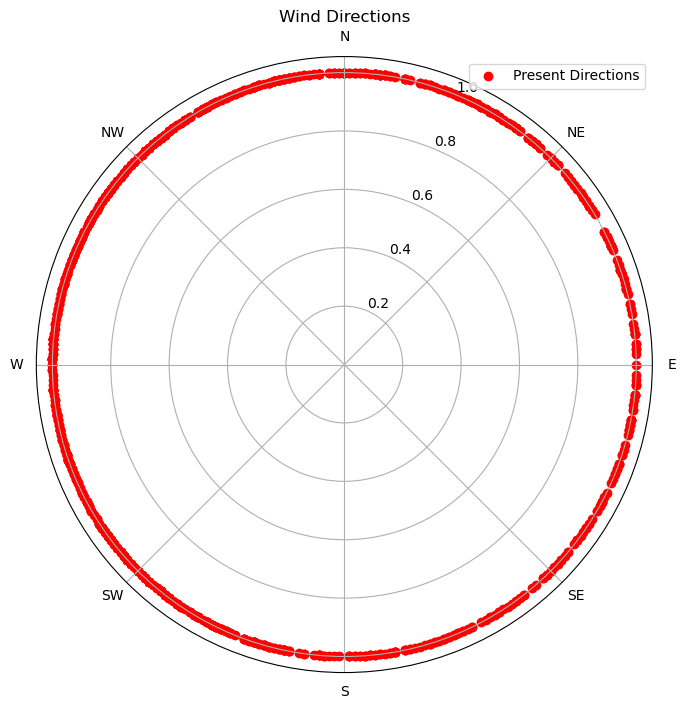

The shape of data is:
(852980, 43)
The mean of IS_FIRE is:
0.0006787966892541443
The count of IS_FIRE is:
579


In [121]:
Eval_south = data_prep(Eval_data, eval_dat=True,
                          eval_year=2020, 
                          feature_list=feature_list, 
                          area='south', 
                          wind_speed_threshold=0, 
                          #wind_direction_range=[360, 100], 
                          month_list=[9,10,11,12,1,2,3,4])

In [96]:
# train XGBoost model
X_train = Train_south.drop(columns=['IS_FIRE'])
y_train = Train_south['IS_FIRE']

mod_2 = xgb.XGBClassifier(eval_metric='logloss')
mod_2.fit(X_train, y_train)
X_train.columns

Index(['dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'pdsi',
       'max_air_temperature', 'max_relative_humidity', 'min_air_temperature',
       'min_relative_humidity', 'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'SWE',
       'Band1', 'LAI', 'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Native Desert ',
       'veg_Native Grassland ', 'veg_Native Inland Scrub ',
       'veg_Native Oak Woodland ', 'veg_Native Wetland ',
       'veg_Non-native forest ', 'veg_Non-native grassland ',
       'veg_Non-native shrub ', 'veg_Riparian ', 'veg_Urban ', 'veg_Water '],
      dtype='object')

In [97]:
len(features)

37

In [98]:
features = X_train.columns
evaluate_model(mod_2, Train_south, features, "IS_FIRE", print_output=True, plot_ROC=False)

ROC AUC: 1.00
Area Under Precision-Recall Curve (AUC-PR): 1.00
Threshold: 0.50
Precision: 100.00%
Recall: 95.33%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg     60722         0
True Pos        14       286


(1.0, 1.0, 286, 60722, 0, 14, 1.0, 0.9533333333333334, 0.9761092150170648)

In [102]:
features = X_train.columns
evaluate_model(mod_2, Eval_south, features, "IS_FIRE", threshold=0.2, print_output=True, plot_ROC=False)

ROC AUC: 0.79
Area Under Precision-Recall Curve (AUC-PR): 0.00
Threshold: 0.20
Precision: 0.62%
Recall: 0.54%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg    198217       161
True Pos       183         1


(0.7871843093137518,
 0.004222745476754882,
 1,
 198217,
 161,
 183,
 0.006172839506172839,
 0.005434782608695652,
 0.005780346820809249)